In [100]:
! pip install "cohere==5" hnswlib -q

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3.9 -m pip install --upgrade pip


In [3]:
from PIL import Image
from IPython.display import display, HTML
import requests # We can take this out once its in the SDK
import cohere
import base64
import hnswlib
import os
co = cohere.Client('<YOUR API KEY HERE>') # We can add a client once 
token='<YOUR API KEY HERE>'

# Step 1: Load a Dataset of images 

In [ ]:
# We've prepared a small image dataset to be used for semantic search - the dataset contains a diverse set of images ranging from natural images to products

folder_path = 'data/multimodal_semantic_search'
files = os.listdir(folder_path)

# Let's view a sample image: 
file_path=os.path.join(folder_path,files[1])
img = Image.open(file_path)
display(img)

# Step 2: Define a function that will convert the images into base64, encode as a dataurl, and then pass it to the embedding model

In [103]:
# Define a function to convert each image into base64 Data URL and then call our embed model
def image_to_base64_data_url(image_path):

    with open(image_path, "rb") as f:
        enc_img = base64.b64encode(f.read()).decode('utf-8')
        enc_img = f"data:image/jpeg;base64,{enc_img}"


    url = "https://api.cohere.ai/v1/embed"

    payload = {
        "model": "embed-multilingual-v3.0",
        "input_type": "image",
        "embedding_types": ["float"],
        "images": [enc_img]
    }

    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {token}"
    }

    response = requests.request("POST", url, json=payload, headers=headers).json()
    print(response)
    
    return response

# Compute the embeddings and then store in a vector index

In [107]:
# Embed Images and store the full response in an array
embedding_objects=[]
embeddings=[]
file_paths=[]

for file in files: 
    file_path=os.path.join(folder_path,file)
    res=image_to_base64_data_url(file_path)
    file_paths.append(file_path)
    embeddings.append(res['embeddings']['float'][0])
    embedding_objects.append(res)

{'id': '8a9f04b3-7a22-45dd-a11d-586d9c33b960', 'texts': [], 'images': [{'width': 512, 'height': 512, 'format': 'jpeg', 'bit_depth': 24}], 'embeddings': {'float': [[0.002960205, 0.07330322, -0.03201294, -0.004146576, -0.025482178, 0.015655518, 0.070129395, -0.009757996, -0.0022907257, -0.009185791, 0.009300232, -0.023040771, 0.003063202, 0.009887695, 0.031341553, -0.024002075, -0.053894043, -0.022827148, 0.020614624, 0.011726379, -0.009231567, 0.0038070679, -0.026153564, 0.039642334, -0.016998291, 0.017700195, 0.021835327, 0.010482788, 0.052215576, -0.013114929, -0.022964478, 0.03366089, 0.016983032, 0.014442444, 0.037872314, 0.00073862076, -0.028945923, -0.047027588, -0.030593872, -0.07128906, -0.01725769, -0.019836426, 0.015312195, -0.008659363, -0.03286743, -0.03768921, -0.04168701, -0.0259552, 0.027420044, 0.068115234, -0.023223877, -0.039123535, -0.048828125, -0.01676941, -0.021575928, 0.033172607, -0.012207031, -0.008766174, -0.015991211, 0.0368042, -0.03274536, 0.025543213, 0.035

In [108]:
# Create the hnsw index
index = hnswlib.Index(space='cosine', dim=1024)
index.init_index(max_elements=len(embeddings), ef_construction=512, M=64)
index.add_items(embeddings,list(range(len(embeddings))))

# Ask Queries against the Database

The most relevant photo in the top 10 retreived images with a distance score of: 0.84


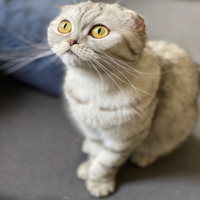

The least relevant photo in the 10 retreived images with a distance score of: 0.86


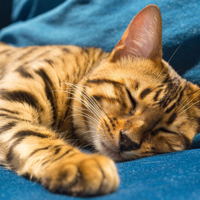

In [109]:
# Set these paramters and query your database
query = "Animals but preferably a gray cat"
top_k=10
size = (200, 200)

# Convert the query into embeddings
query_emb=co.embed(
    texts=[query], model="embed-multilingual-v3.0", input_type="search_query"
        ).embeddings

# Retrieve the initial results from your vector db
res = index.knn_query(query_emb, k=top_k)
doc_index=res[0][0]
doc_scores=res[1][0]

# Let's view the response image: 
print(f"The most relevant photo in the top {top_k} retreived images with a distance score of: {doc_scores[0]:.2f}")
img = Image.open(file_paths[doc_index[0]])
img_resized = img.resize(size)
display(img_resized)

print(f"The least relevant photo in the {top_k} retreived images with a distance score of: {doc_scores[4]:.2f}")
img = Image.open(file_paths[doc_index[4]])
img_resized = img.resize(size)
display(img_resized)

Ranking of Relevance:1 with a distance of: 0.84


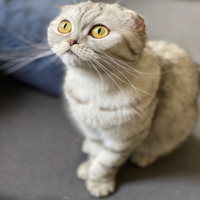

Ranking of Relevance:2 with a distance of: 0.84


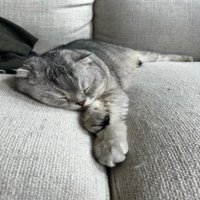

Ranking of Relevance:3 with a distance of: 0.84


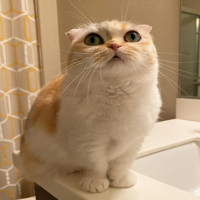

Ranking of Relevance:4 with a distance of: 0.84


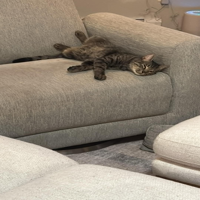

Ranking of Relevance:5 with a distance of: 0.84


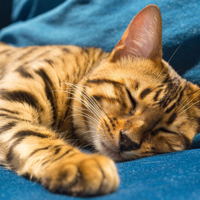

Ranking of Relevance:6 with a distance of: 0.84


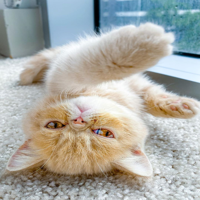

Ranking of Relevance:7 with a distance of: 0.84


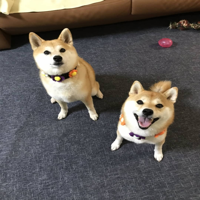

Ranking of Relevance:8 with a distance of: 0.84


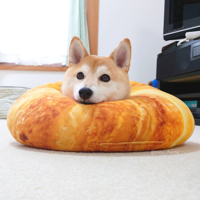

Ranking of Relevance:9 with a distance of: 0.84


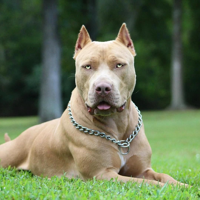

Ranking of Relevance:10 with a distance of: 0.84


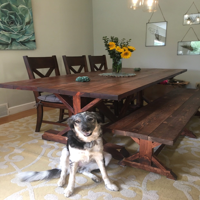

In [110]:
# For the full list of images grabbed: 
for x in range(0,len(doc_index)):
    print(f"Ranking of Relevance:{x+1} with a distance of: {doc_scores[0]:.2f}")
    img = Image.open(file_paths[doc_index[x]])
    img_resized = img.resize(size)
    display(img_resized)